In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_model import ARIMA

In [2]:
df=pd.read_csv("212_Temp.csv")

In [3]:
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date')

In [4]:
df.dropna(inplace=True)

In [5]:
ts=df.loc['1/15/2020':'2/15/2020']['Temperature']
#ts=pd.DataFrame(ts)
ts.tail()

Date
2020-02-15 15:42:00    63.6
2020-02-15 17:42:00    66.4
2020-02-15 19:42:00    67.2
2020-02-15 21:42:00    67.3
2020-02-15 23:42:00    68.2
Name: Temperature, dtype: float64

In [6]:
ts.shape

(384,)

# 1st approach

In [7]:
# Create Training and Test
train = ts[:288]
test = ts[288:]

In [59]:
#building the model
import pmdarima as pm
from pmdarima.arima import auto_arima

model = pm.auto_arima(train, start_p=1, start_q=1, seasonal=True, m=12)

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check

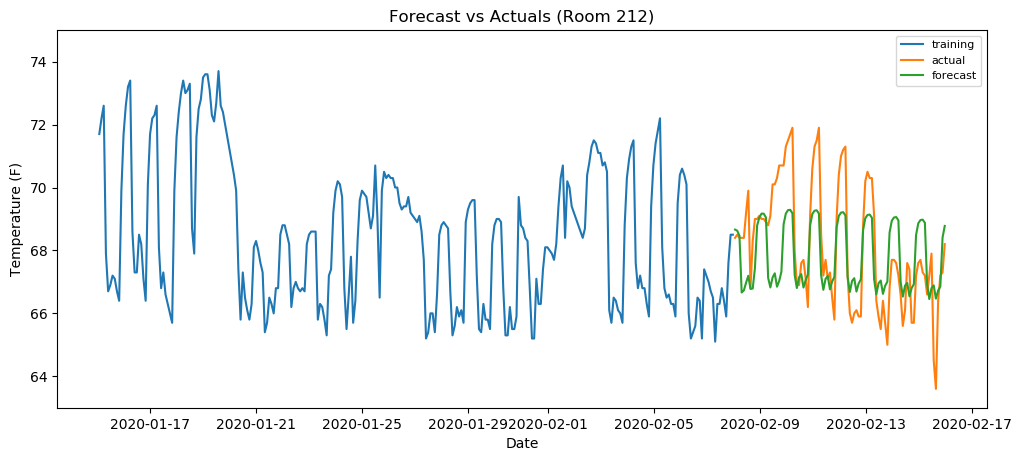

RMSE: 1.5185


In [60]:
# make your forecasts
forecasts = model.predict(96)  # predict N steps into the future

# Visualize the forecasts (blue=train, green=forecasts)
plt.figure(figsize=(12,5), dpi=100)
plt.plot(ts.index[:288],train.values, label='training')
plt.plot(ts.index[288:],test.values, label='actual')
plt.plot(ts.index[288:],forecasts, label='forecast')
#plt.fill_between(lower_series.index, lower_series, upper_series,color='k', alpha=.15)
plt.title('Forecast vs Actuals (Room 212)')
plt.legend(loc='best', fontsize=8)
plt.ylim(63,75)
plt.xlabel('Date')
plt.ylabel('Temperature (F)')
plt.show()

print('RMSE: %.4f'% np.sqrt(sum((test.values-forecasts)**2)/len(forecasts)))

# 2nd approach

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency 2H will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency 2H will be used.
  % freq, ValueWarning)


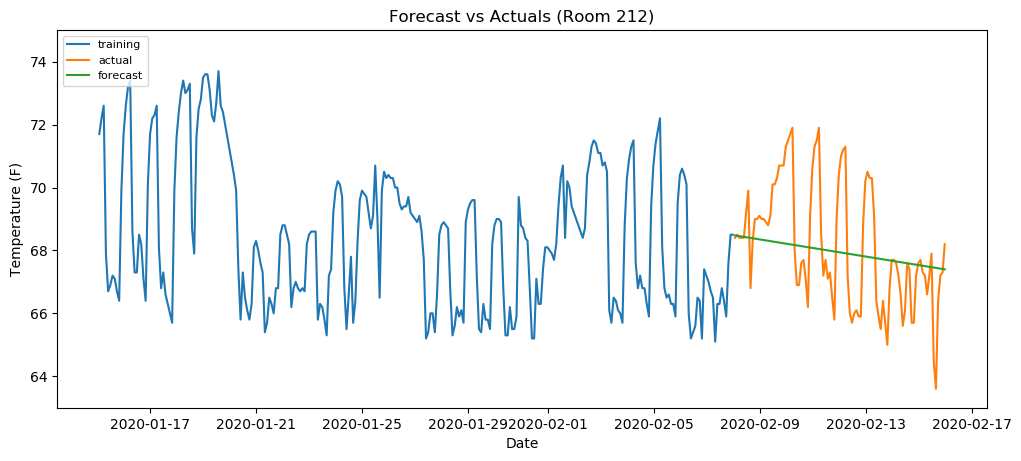

In [61]:
# Build Model
# model = ARIMA(train, order=(3,2,1))  
model = ARIMA(train, order=(1, 1, 1))  
fitted = model.fit(disp=-1)  

# Forecast
fc, se, conf = fitted.forecast(96, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
#plt.fill_between(lower_series.index, lower_series, upper_series,color='k', alpha=.15)
plt.title('Forecast vs Actuals (Room 212)')
plt.legend(loc='upper left', fontsize=8)
plt.ylim(63,75)
plt.xlabel('Date')
plt.ylabel('Temperature (F)')
plt.show()

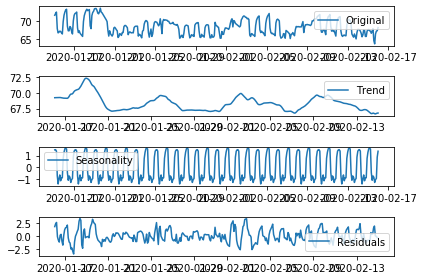

In [9]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [10]:
print('RMSE: %.4f'% np.sqrt(sum((fc_series-test)**2)/len(fc_series)))

RMSE: 1.7723


# 3rd approach

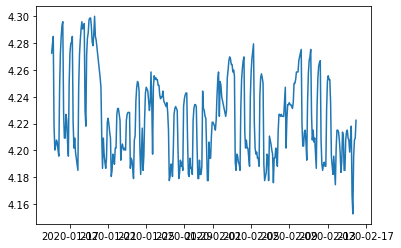

In [11]:
ts_log = np.log(ts)
plt.plot(ts_log)

In [12]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(6).mean()
    rolstd = timeseries.rolling(6).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

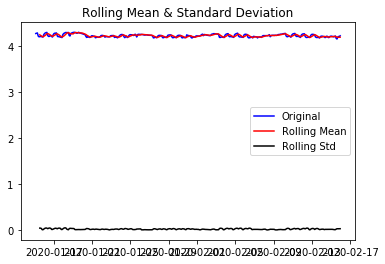

Results of Dickey-Fuller Test:
Test Statistic                  -3.521534
p-value                          0.007451
#Lags Used                      12.000000
Number of Observations Used    371.000000
Critical Value (1%)             -3.448100
Critical Value (5%)             -2.869362
Critical Value (10%)            -2.570937
dtype: float64


In [13]:
test_stationarity(ts_log)

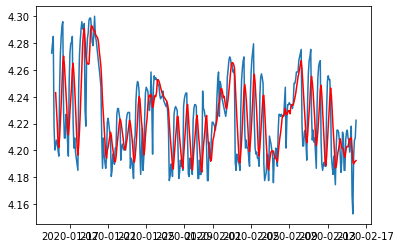

In [14]:
moving_avg = ts_log.rolling(6).mean()
plt.plot(ts_log)
plt.plot(moving_avg, color='red')

In [15]:
ts_moving_avg_diff=ts_log-moving_avg
ts_moving_avg_diff.dropna(inplace=True)
ts_moving_avg_diff.head()

Date
2020-01-15 11:42:00   -0.039857
2020-01-15 13:42:00   -0.024580
2020-01-15 15:42:00   -0.013860
2020-01-15 17:42:00   -0.005712
2020-01-15 19:42:00   -0.006497
Name: Temperature, dtype: float64

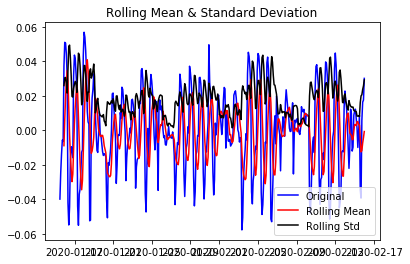

Results of Dickey-Fuller Test:
Test Statistic                -6.287763e+00
p-value                        3.662279e-08
#Lags Used                     1.200000e+01
Number of Observations Used    3.660000e+02
Critical Value (1%)           -3.448344e+00
Critical Value (5%)           -2.869469e+00
Critical Value (10%)          -2.570994e+00
dtype: float64


In [16]:
test_stationarity(ts_moving_avg_diff)

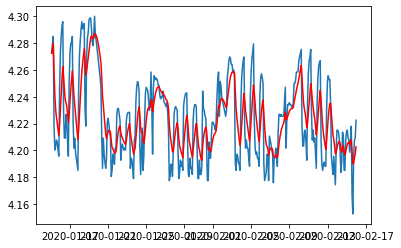

In [17]:
expwighted_avg = ts_log.ewm(halflife=3).mean()
plt.plot(ts_log)
plt.plot(expwighted_avg, color='red')

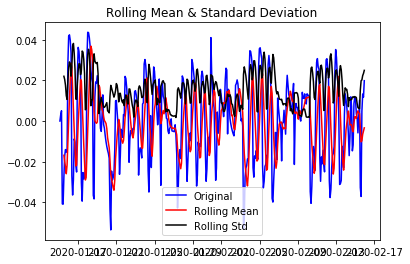

Results of Dickey-Fuller Test:
Test Statistic                  -5.158665
p-value                          0.000011
#Lags Used                      12.000000
Number of Observations Used    371.000000
Critical Value (1%)             -3.448100
Critical Value (5%)             -2.869362
Critical Value (10%)            -2.570937
dtype: float64


In [18]:
ts_ewma_diff = ts_log - expwighted_avg
test_stationarity(ts_ewma_diff)

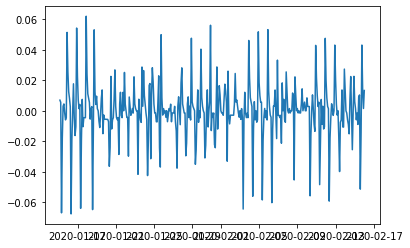

In [19]:
ts_diff=ts_log-ts_log.shift()
plt.plot(ts_diff)

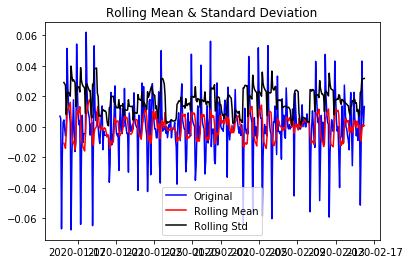

Results of Dickey-Fuller Test:
Test Statistic                -6.220509e+00
p-value                        5.237384e-08
#Lags Used                     1.100000e+01
Number of Observations Used    3.710000e+02
Critical Value (1%)           -3.448100e+00
Critical Value (5%)           -2.869362e+00
Critical Value (10%)          -2.570937e+00
dtype: float64


In [20]:
ts_diff.dropna(inplace=True)
test_stationarity(ts_diff)

In [21]:
#ts_diff=ts_diff-ts_diff.shift()
#plt.plot(ts_diff)

In [22]:
#ts_diff.dropna(inplace=True)
#test_stationarity(ts_diff)

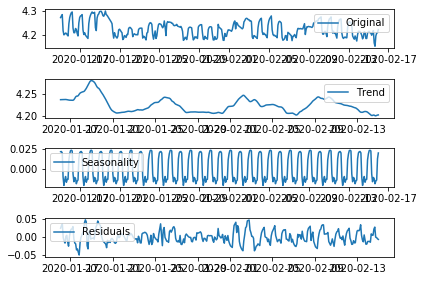

In [23]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

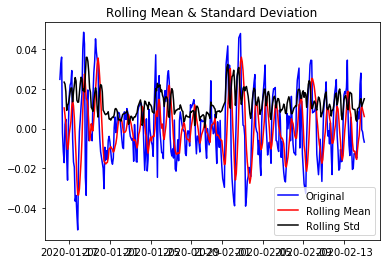

Results of Dickey-Fuller Test:
Test Statistic                -6.859473e+00
p-value                        1.616323e-09
#Lags Used                     1.200000e+01
Number of Observations Used    3.470000e+02
Critical Value (1%)           -3.449337e+00
Critical Value (5%)           -2.869906e+00
Critical Value (10%)          -2.571227e+00
dtype: float64


In [24]:
ts_decompose = residual
ts_decompose.dropna(inplace=True)
test_stationarity(ts_decompose)

In [25]:
#ACF and PACF plots:
from statsmodels.tsa.stattools import acf, pacf

In [26]:
lag_acf = acf(ts_diff, nlags=6)
lag_pacf = pacf(ts_diff, nlags=6, method='ols')

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning


Text(0.5, 1.0, 'Autocorrelation Function')

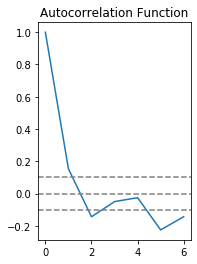

In [27]:
#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

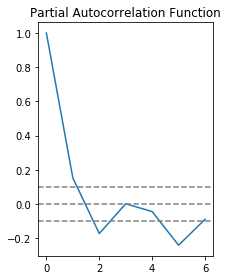

In [28]:
#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

In [29]:
from statsmodels.tsa.arima_model import ARIMA

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency 2H will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency 2H will be used.
  % freq, ValueWarning)


Text(0.5, 1.0, 'RSS: 0.1344')

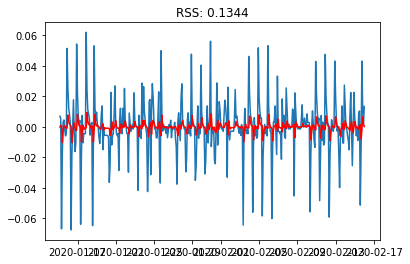

In [30]:
model = ARIMA(ts_log, order=(1, 1, 0))  
results_AR = model.fit(disp=-1)
a=results_AR.fittedvalues
a.index=ts_diff.index
plt.plot(ts_diff)
plt.plot(a, color='red')
plt.title('RSS: %.4f'% sum((a-ts_diff)**2))

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency 2H will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency 2H will be used.
  % freq, ValueWarning)


Text(0.5, 1.0, 'RSS: 0.1330')

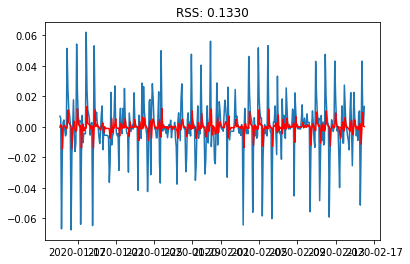

In [31]:
model = ARIMA(ts_log, order=(0, 1, 1))  
results_MA = model.fit(disp=-1)
b=results_MA.fittedvalues
b.index=ts_diff.index
plt.plot(ts_diff)
plt.plot(b, color='red')
plt.title('RSS: %.4f'% sum((results_MA.fittedvalues-ts_diff)**2))

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency 2H will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency 2H will be used.
  % freq, ValueWarning)


Text(0.5, 1.0, 'RSS: 0.1322')

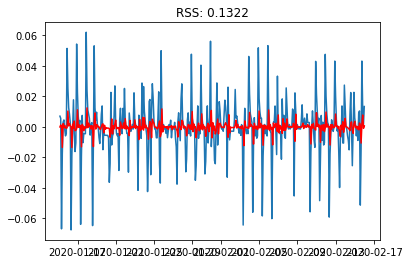

In [32]:
model = ARIMA(ts_log, order=(1, 1, 1))  
results_ARIMA = model.fit(disp=-1)  
c=results_ARIMA.fittedvalues
c.index=ts_diff.index
plt.plot(ts_diff)
plt.plot(c, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-ts_diff)**2))

In [33]:
print(results_ARIMA.summary())

                             ARIMA Model Results                              
Dep. Variable:          D.Temperature   No. Observations:                  383
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 983.093
Method:                       css-mle   S.D. of innovations              0.019
Date:                Thu, 07 May 2020   AIC                          -1958.186
Time:                        13:58:47   BIC                          -1942.394
Sample:                    01-15-2020   HQIC                         -1951.921
                         - 02-15-2020                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -0.0001      0.001     -0.116      0.907      -0.002       0.002
ar.L1.D.Temperature    -0.2238      0.133     -1.679      0.093      -0.485       0.037
ma.L1.D.Temperat

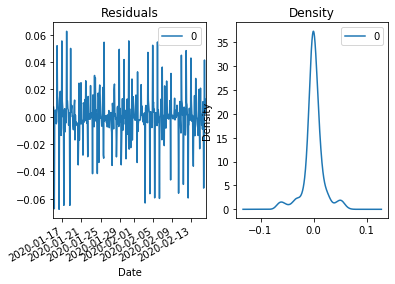

In [34]:
residuals = pd.DataFrame(results_ARIMA.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

In [35]:
#results_ARIMA.plot_predict(dynamic=False)
#plt.show()

In [36]:
#AR forecast

In [37]:
predictions_AR_diff = pd.Series(results_AR.fittedvalues, copy=True)
predictions_AR_diff.head()

Date
2020-01-15 03:42:00   -0.000121
2020-01-15 05:42:00    0.000961
2020-01-15 07:42:00    0.000743
2020-01-15 09:42:00   -0.010346
2020-01-15 11:42:00   -0.002832
dtype: float64

In [38]:
predictions_AR_diff_cumsum = predictions_AR_diff.cumsum()
predictions_AR_diff_cumsum.head()

Date
2020-01-15 03:42:00   -0.000121
2020-01-15 05:42:00    0.000840
2020-01-15 07:42:00    0.001583
2020-01-15 09:42:00   -0.008763
2020-01-15 11:42:00   -0.011595
dtype: float64

In [39]:
predictions_AR_log = pd.Series(ts_log.ix[0], index=ts_log.index)
predictions_AR_log = predictions_AR_log.add(predictions_AR_diff_cumsum,fill_value=0)
predictions_AR_log.head()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


Date
2020-01-15 01:42:00    4.272491
2020-01-15 03:42:00    4.272370
2020-01-15 05:42:00    4.273331
2020-01-15 07:42:00    4.274074
2020-01-15 09:42:00    4.263728
dtype: float64

Text(0, 0.5, 'Temperature (F)')

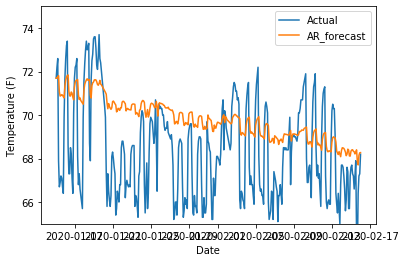

In [40]:
predictions_AR = np.exp(predictions_AR_log)
plt.plot(ts,label='Actual')
plt.plot(predictions_AR,label='AR_forecast')
plt.legend(loc="upper right")
plt.ylim(65,75)
plt.xlabel('Date')
plt.ylabel('Temperature (F)')

In [41]:
print('RMSE: %.4f'% np.sqrt(sum((predictions_AR-ts)**2)/len(ts)))

RMSE: 2.3761


In [42]:
#MA forecast

In [43]:
predictions_MA_diff = pd.Series(results_MA.fittedvalues, copy=True)
predictions_MA_diff.head()

Date
2020-01-15 03:42:00   -0.000122
2020-01-15 05:42:00    0.001323
2020-01-15 07:42:00    0.000774
2020-01-15 09:42:00   -0.014579
2020-01-15 11:42:00   -0.000816
dtype: float64

In [44]:
predictions_MA_diff_cumsum = predictions_MA_diff.cumsum()
predictions_MA_diff_cumsum.head()

Date
2020-01-15 03:42:00   -0.000122
2020-01-15 05:42:00    0.001201
2020-01-15 07:42:00    0.001975
2020-01-15 09:42:00   -0.012604
2020-01-15 11:42:00   -0.013420
dtype: float64

In [45]:
predictions_MA_log = pd.Series(ts_log.ix[0], index=ts_log.index)
predictions_MA_log = predictions_MA_log.add(predictions_MA_diff_cumsum,fill_value=0)
predictions_MA_log.head()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


Date
2020-01-15 01:42:00    4.272491
2020-01-15 03:42:00    4.272369
2020-01-15 05:42:00    4.273692
2020-01-15 07:42:00    4.274466
2020-01-15 09:42:00    4.259887
dtype: float64

Text(0, 0.5, 'Temperature (F)')

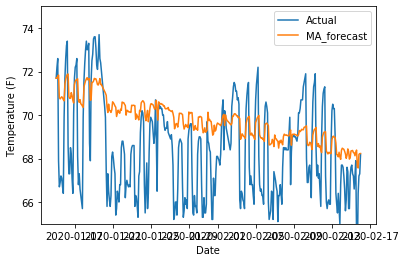

In [46]:
predictions_MA = np.exp(predictions_MA_log)
plt.plot(ts,label='Actual')
plt.plot(predictions_MA,label='MA_forecast')
plt.legend(loc="upper right")
plt.ylim(65,75)
plt.xlabel('Date')
plt.ylabel('Temperature (F)')

In [47]:
print('RMSE: %.4f'% np.sqrt(sum((predictions_MA-ts)**2)/len(ts)))

RMSE: 2.3028


In [48]:
#ARIMA forecast

In [49]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
predictions_ARIMA_diff.head()

Date
2020-01-15 03:42:00   -0.000128
2020-01-15 05:42:00    0.001154
2020-01-15 07:42:00    0.000437
2020-01-15 09:42:00   -0.013544
2020-01-15 11:42:00    0.002026
dtype: float64

In [50]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_diff_cumsum.head()

Date
2020-01-15 03:42:00   -0.000128
2020-01-15 05:42:00    0.001026
2020-01-15 07:42:00    0.001462
2020-01-15 09:42:00   -0.012081
2020-01-15 11:42:00   -0.010055
dtype: float64

In [51]:
predictions_ARIMA_log = pd.Series(ts_log.ix[0], index=ts_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA_log.head()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


Date
2020-01-15 01:42:00    4.272491
2020-01-15 03:42:00    4.272363
2020-01-15 05:42:00    4.273516
2020-01-15 07:42:00    4.273953
2020-01-15 09:42:00    4.260409
dtype: float64

Text(0, 0.5, 'Temperature (F)')

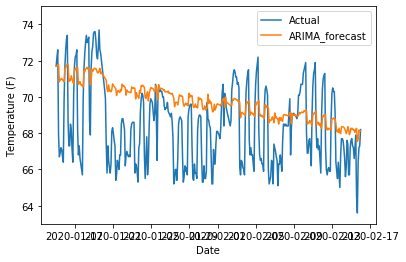

In [52]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(ts,label='Actual')
plt.plot(predictions_ARIMA,label='ARIMA_forecast')
plt.legend(loc="upper right")
plt.ylim(63,75)
plt.xlabel('Date')
plt.ylabel('Temperature (F)')

In [53]:
print('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-ts)**2)/len(ts)))

RMSE: 2.3481
